In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools as itools
import scipy as sc
from pathlib import Path
import random


HERE=Path.cwd()


INIT SYSTEM BLOCK

In [13]:
stab = -1 #(stable system)

In [3]:
# System Initialization

A = np.array([[-1.01887, 0.90506, -0.00215],
    [0.82225, -1.07741, -0.17555],
    [0, 0, stab]])



B = np.array([[0],
              [0],
             [1]])



n = np.shape(A)[0]
m = np.shape(B)[1]
nu = (n+m)*(n+m+1)/2

M = 1*np.diag(np.ones(n))
# print('M=', M)

R = 1*np.diag(np.ones(m))

a_c = 50

a_u = 1

a_g = 1

T_e = 30

T = 0.1


hh = 0.05
step = T/hh




Q-FUNCTION CREATION BLOCK

In [4]:
# Q-Function Creation #

def Qcreate(Wc, n=n, m=m, nu=nu):
    
    
    Q = np.zeros((n+m, n+m))
    idx = np.triu_indices(n+m)
    crit_p = Wc
    Q[idx] = crit_p.reshape((int(nu),))
    Q = Q + Q.T
    

    Qxx = Q[0:n,0:n]
    Quu = Q[n:n+m,n:n+m]
    Qxu = Q[0:n,n:n+m]
    
    
    M = 1*np.diag(np.ones(n))
    Z = np.zeros((m,n))
    addcol = np.vstack((-1*M,Z))
#     print(addcol)
#     print(Q)
    addrow = np.hstack((-1*M,Z.T,M))
    Q_b = np.hstack((Q,addcol))
    Q_b = np.vstack((Q_b,addrow))
    
    return Q, Qxx, Quu, Qxu, Q_b




INITIALIZING WEIGHTS

In [5]:
# Tradeoff IR+ER and Q Learning Optimal Weights Stable Systems


Wc = np.array([[-1.33968616],
                [ 1.28255975],
                [ 1.24431244],
                [ 0.15947273],
                [-0.33489957],
                [ 0.76779848],
                [ 0.9676142 ],
                [ 0.57104663],
                [ 0.13504564],
                [ 0.76662278]])

Wu = np.array([[ 0.33656426],
                [ 0.17367648],
                [-0.44974277]])

Wg = np.array([[ 0.44918194],
                [ 0.99675306],
                [-1.7465727 ],
                [ 0.67812254],
                [ 0.15293051],
                [-1.64427565],
                [-1.90095774],
                [ 0.72576712],
                [-0.5332877 ],
                [ 1.21135117]])

# System Setup: Flattening Weights

x = np.array([[1, 1, 0]]).T

u = np.matmul(Wu.T,x)
U = np.vstack((x,u))

Wu_vec = Wu.reshape((n*m,1))
p = 0.5*hh*(np.matmul(x.T, np.matmul(M, x)) + np.matmul(u.T, np.matmul((R), u)))

Qg,_,_,_,_ = Qcreate(Wg)
s = 0.5*hh*np.matmul(U.T, np.matmul(Qg, U))


# y = np.vstack((x,Wc,Wu_vec,p))
y = np.vstack((x,Wc,Wu_vec,s))
tspan = 50

# System Setup: Flattening Weights

x = np.array([[1, 1, 0]]).T

u = np.matmul(Wu.T,x)
U = np.vstack((x,u))

Wu_vec = Wu.reshape((n*m,1))
p = 0.5*hh*(np.matmul(x.T, np.matmul(M, x)) + np.matmul(u.T, np.matmul((R), u)))

Qg,_,_,_,_ = Qcreate(Wg)
s = 0.5*hh*np.matmul(U.T, np.matmul(Qg, U))


# y = np.vstack((x,Wc,Wu_vec,p))
y = np.vstack((x,Wc,Wu_vec,s))
tspan = 50



THE EULER BLOCK 

In [6]:
# Euler's Method #

def euler_state(x, u, A_mat = A, B_mat = B, h = hh):
    states_sys = np.matmul(A_mat,x) + np.matmul(B_mat,u)
    x_n = x + h*states_sys
    
    return x_n

def euler_critic(U, p, p_p, U_p, Wc, Q_mat, h = hh, cs = a_c):
    
#     current_est = np.matmul(U.T, np.matmul(Q_mat, U))
#     past_est = np.matmul(U_p.T, np.matmul(Q_mat, U_p))
    integral_error = p - p_p
    
#     ec = 0.5*(current_est - past_est + integral_error)
    basis_idx = list(itools.combinations_with_replacement(range(n+m),2))
    
    phil = []
    phil_p = []
    for i,j in basis_idx:
        phil.append(U[i]*U[j])
        phil_p.append(U_p[i]*U_p[j])
        
    phi = np.array(phil).reshape(len(basis_idx))
    phi_p = np.array(phil_p).reshape(len(basis_idx))
        
        
    sigma = phi-phi_p
    ec = np.matmul(sigma.T, Wc) + integral_error
    critic_sys = -1*cs*(sigma/(1+np.dot(sigma,sigma))**2)*ec
    # print('Wc shape is')
    # print(Wc.shape)

    # print('critic sys shape is')
    # print(critic_sys.shape)
    Wc_n = Wc + h*critic_sys.T

    # print('Wc_n shape is')
    # print(Wc_n.shape)
    return Wc_n

def euler_actor(x, Wa, Q_uu, Q_ux, h = hh, a_s = a_u):
    ea = np.matmul(Wa.T, x) + np.matmul(np.linalg.inv(Q_uu),np.matmul(Q_ux,x))
    phiu = x
    phiu_norm = phiu/(1+np.dot(phiu.T,phiu))**2
    actor_sys = -1*a_s*np.matmul(phiu_norm,ea.T)
    Wa_n = Wa + h*actor_sys
    return Wa_n

def euler_IR(Wg, U, h = hh, ug = 0, a_s=a_g):
    basis_idx = list(itools.combinations_with_replacement(range(n+m),2))
    
    phil = []
    # phil_p = []
    for i,j in basis_idx:
        phil.append(U[i]*U[j])
        # phil_p.append(U_p[i]*U_p[j])
        
    phi = np.array(phil).reshape(len(basis_idx))
    # phi_p = np.array(phil_p).reshape(len(basis_idx))
        
        
    sigma = phi

    eg = abs(ug - np.matmul(sigma.T, Wg)) 
    # sigT*Wg = phiT*Wg = (UkronU)T*Wg = UT*Qg*U
    # print('eg shape is')
    # print(eg)
    goal_sys = -1*a_s*(sigma/(1+np.dot(sigma,sigma))**2)*eg

    # print('goal sys shape is')
    # print(goal_sys.shape)

    # print('Wg is')
    # print(Wg)

    # print('Wg shape is')
    # print(Wg.shape)

    # print('sum1')
    # print(Wg.shape)


    # print('sum2')
    # print(h)


    Wg_n = Wg + h*goal_sys.reshape(Wg.shape)


    return Wg_n

    



Q LEARNING VANILLA

In [14]:
#Q-learning Block


U_series = []
x_series = []
u_series = []
Wc_series = []
Wu_series = []
p_series = []
rxu_series = []



U_series.append(U)
x_series.append(x)
u_series.append(u)
Wc_series.append(Wc) 
Wu_series.append(Wu)
p_series.append(p)
rxu_series.append(p)


for t in np.arange(hh,100,hh):
#     print('t=',t)
    x_n = euler_state(x_series[-1], u_series[-1])
    
    step = int(step)
#     print('Wc_series=',Wc_series)
    Q, Qxx, Quu, Qxu, Qb = Qcreate(Wc_series[-1])
    Qux = Qxu.T
    
    
    
    if len(p_series) < step:
        st = -1
#         p_pp = p_series[-step]
#         u_pp = u_series[-step]
#         x_pp = x_series[-step]
        
    else:
        st = -step
#         p_pp = p_series[-1]
#         u_pp = u_series[-1]
#         x_pp = x_series[-1]
    
    Wc_n = euler_critic(U_series[-1], p_series[-1], p_series[st], U_series[st], Wc_series[-1], Q)
    Wu_n = euler_actor(x_series[-1], Wu_series[-1], Quu, Qux)
    
#     print('Wc_n = ', Wc_n)
    
    u_new = np.matmul(Wu_n.T,x_n)
    
    p_now = np.matmul(x_n.T, np.matmul(M, x_n)) + np.matmul(u_new.T, np.matmul((R), u_new))
    
    p_n = p_series[-1] + 0.5*hh*p_now
    
    if t < T_e:
#         u_n = u_new + 0.2*np.exp(-0.0000001*t)*(np.sin(4*t**2)**2*np.cos(t**2)+np.sin(2**t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
        u_n = u_new  + 2*np.exp(-0.01*t)*(np.sin(100*t)+np.sin(t)**2*np.cos(t)+np.sin(2*t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
    else:
        u_n = u_new
        
#     p_past = np.matmul(x_series[-1].T, np.matmul(M, x_series[-1])) + np.matmul(u_series[-1].T, np.matmul((R), u_series[-1]))

    
    x_series.append(x_n)
    Wc_series.append(Wc_n)
    Wu_series.append(Wu_n)
    u_series.append(u_n)
    
    
    U_n = np.vstack((x_n,u_n))
    U_series.append(U_n)
    p_series.append(p_n)
    rxu_series.append(p_now)


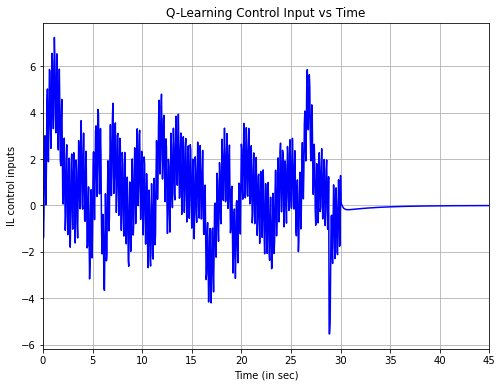

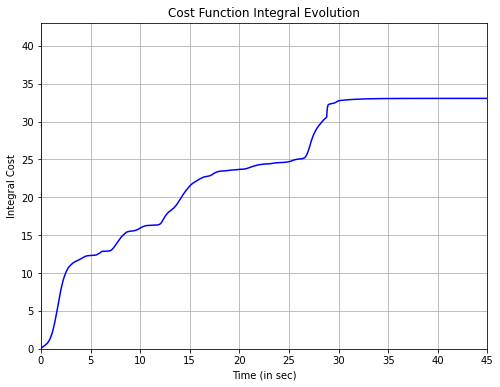

In [15]:
# Controller plot
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.plot(np.arange(0,100,hh), np.array(u_series).reshape(2000), 'b')
plt.xlim([0, 45])
plt.title('Q-Learning Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('IL control inputs')
ax3.grid()
plt.show(fig3)

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.plot(np.arange(0,100,hh), np.array(p_series).reshape(2000), 'b')
plt.xlim([0, 45])
plt.ylim([0, 10 + np.max(np.array(p_series))])
plt.title('Cost Function Integral Evolution')
plt.xlabel('Time (in sec)')
plt.ylabel('Integral Cost')
ax4.grid()
plt.show(fig4)

# np.max(np.array(p_series))

INTERNAL + EXTERNAL REWARD BLOCK

In [16]:
# Internal reward Block tradeoff between IR and ER
pt = 1
counts = 0
countr = 0

U_ix_series = []
x_ix_series = []
u_ix_series = []
Wc_ix_series = []
Wu_ix_series = []
Wg_ix_series = []
p_ix_series = [] #Integral of p(t)r(x,u) + (1-p(t))s(x,u)
r_ix_series = [] #Integral of r(x,u) (true)
rxu_ix_series = [] #reward signal (true)
s_ix_series =[] #Integral of internal reward s(x,u)
sxu_ix_series = [] #internal reward 



U_ix_series.append(U)
x_ix_series.append(x)
u_ix_series.append(u)
Wc_ix_series.append(Wc) 
Wu_ix_series.append(Wu)
Wg_ix_series.append(Wg)
p_ix_series.append(p) #assuming we start with access to r(x,u) (pt = 1)
r_ix_series.append(p)
rxu_ix_series.append(p)
s_ix_series.append(s)
sxu_ix_series.append(s)


for t in np.arange(hh,100,hh):
    x_n = euler_state(x_ix_series[-1], u_ix_series[-1])
    
    step = int(step)
    Q, Qxx, Quu, Qxu, Qb = Qcreate(Wc_ix_series[-1])
    Qux = Qxu.T

    Qg,_,_,_,_ = Qcreate(Wg_ix_series[-1])
    
    
    
    
    if len(p_ix_series) < step:
        st = -1   
    else:
        st = -step

    # p_c = r_ix_series[-1]
    # p_p = r_ix_series[st]

    # s_c = s_ix_series[-1]
    # s_p = s_ix_series[st]

    """
     A conditional to check if p(t) is zero or 1
    If it is zero, then we use s(t) (the learned reward)
    If it is 1, we use rxu (the real reward available)

    p(t)r(t) + (1-p(t))s(t)

    """
    if pt == 0:
        sg = np.matmul(U_ix_series[-1].T, np.matmul(Qg, U_ix_series[-1]))
        # sigT*Wg = phiT*Wg = (UkronU)T*Wg = UT*Qg*U
        # print("loss")

        # counts = counts + 1
        # if counts == 5:
        #     pt = 1 - pt
        #     counts = 0
    elif pt == 1:
        sg = rxu_ix_series[-1]
        # print("track")

        # countr = countr + 1
        # if countr == 10:
        #     pt = 1 - pt
        #     countr = 0



    
    Wc_n = euler_critic(U_ix_series[-1], p_ix_series[-1], p_ix_series[st], U_ix_series[st], Wc_ix_series[-1], Q)
    Wu_n = euler_actor(x_ix_series[-1], Wu_ix_series[-1], Quu, Qux)
    Wg_n = euler_IR(Wg_ix_series[-1], U_ix_series[-1], ug = sg) 
    
    
    u_new = np.matmul(Wu_n.T,x_n)
    
   
    
    if t < T_e:
#         u_n = u_new + 0.2*np.exp(-0.0000001*t)*(np.sin(4*t**2)**2*np.cos(t**2)+np.sin(2**t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
        u_n = u_new  + 2*np.exp(-0.01*t)*(np.sin(100*t)+np.sin(t)**2*np.cos(t)+np.sin(2*t)**2*np.cos(0.1*t)+np.sin(-1.2*t)**2*np.cos(0.5*t)+np.sin(t)**5+np.sin(1.12*t)**2+np.cos(2.4*t)*np.sin(2.4*t)**3)
    else:
        u_n = u_new
        
    """
    if p(t) = 1:
        r_now updates as in the equation below
        s_now also updates as in equation below
    if p(t) = 0:
        r_now = 0
        s_now as usual in equation below
        
    """ 
    r_now = np.matmul(x_n.T, np.matmul(M, x_n)) + np.matmul(u_new.T, np.matmul((R), u_new))
    
    U_n = np.vstack((x_n,u_new))
    s_now = np.matmul(U_n.T, np.matmul(Qg, U_n)) #removed the 0.5*hh* from the front
    
    r_n = r_ix_series[-1] + 0.5*hh*r_now  
    s_n = s_ix_series[-1] + 0.5*hh*s_now  
    p_n = p_ix_series[-1] + 0.5*hh*(pt*r_now + (1-pt)*s_now) #the combination of the past integral value plus the two rewards 

    if pt == 0:
 
        counts = counts + 1
        if counts == 5:
            pt = 1 - pt
            counts = 0
    elif pt == 1:
        
        countr = countr + 1
        if countr == 1:
            pt = 1 - pt
            countr = 0
    
    # print(pt)
    
    x_ix_series.append(x_n)
    Wc_ix_series.append(Wc_n)
    Wu_ix_series.append(Wu_n)
    Wg_ix_series.append(Wg_n)
    u_ix_series.append(u_n)
    
    
    U_n = np.vstack((x_n,u_n))
    U_ix_series.append(U_n)

    p_ix_series.append(p_n)
    r_ix_series.append(r_n)
    rxu_ix_series.append(r_now)
    s_ix_series.append(s_n)
    sxu_ix_series.append(s_now)


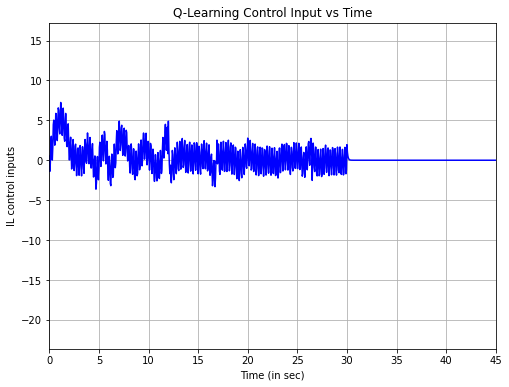

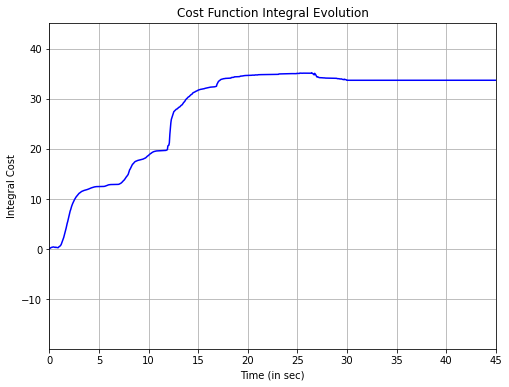

In [17]:
# Controller plot
fig3, ax3 = plt.subplots(figsize=(8, 6))
ax3.plot(np.arange(0,100,hh), np.array(u_ix_series).reshape(2000), 'b')
plt.xlim([0, 45])
plt.ylim([-20 + np.min(np.array(u_ix_series)) ,10+np.max(np.array(u_ix_series))])
plt.title('Q-Learning Control Input vs Time')
plt.xlabel('Time (in sec)')
plt.ylabel('IL control inputs')
ax3.grid()
plt.show(fig3)

fig4, ax4 = plt.subplots(figsize=(8, 6))
ax4.plot(np.arange(0,100,hh), np.array(p_ix_series).reshape(2000), 'b')
plt.xlim([0, 45])
plt.ylim([-20 + np.min(np.array(p_ix_series)),10+np.max(np.array(p_ix_series))])
plt.title('Cost Function Integral Evolution')
plt.xlabel('Time (in sec)')
plt.ylabel('Integral Cost')
ax4.grid()
plt.show(fig4)

Plot error between pretidcted reward and the real reward
Plot what happens as p(t) changes

In the absence of p(t) the two rewards are the same